# Intro to data analysis with pandas

# In-depth pandas tutorial
[Giant pandas tutorial](https://www.youtube.com/watch?v=oGzU688xCUs) and [attendant notes](https://github.com/chendaniely/scipy-2017-tutorial-pandas) available at the links.

# Imports
Allow plots in the notebook itself, and enable some helpful functions

In [112]:
%reset -f
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # High-res graphs (rendered irrelevant by svg option below)
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'} # No extra white space
%config InlineBackend.figure_format = 'svg' # 'png' is default

import warnings
warnings.filterwarnings('ignore') # Because we are adults
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [113]:
data = sns.load_dataset("tips")
data.head()  # show first n entries (default is 5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


# Data exploration

## Histograms

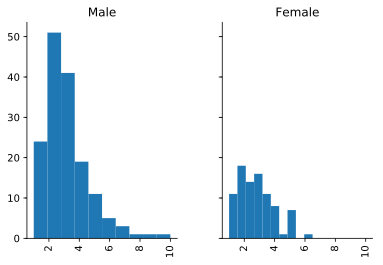

In [117]:
data["tip"].hist(by=data["sex"], sharex=True, sharey=True)
sns.despine()  # Remove top and right side of box

plt.show()  # Somewhat redundant in this context, but suppresses annoying text output.

## Overlaid histograms

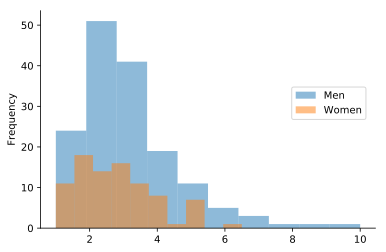

In [118]:
grouped_by_sex = data.groupby("sex")

# You can also add several arguments below like bins=20, or normed=True
figure, axes = grouped_by_sex["tip"].plot(
    kind="hist", normed=False, alpha=0.5, legend=True
)

# Re-label legend entries, move legend to right-middle
axes.legend(["Men", "Women"], loc=(0.75, 0.5))

sns.despine()
plt.show()

## Descriptive statistics

In [119]:
grouped_by_sex["tip"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Male,157.0,3.089618,1.489102,1.0,2.0,3.00,3.76,10.0
Female,87.0,2.833448,1.159495,1.0,2.0,2.75,3.50,6.5


## Subsetting data
Let's get the tips given on Sunday at dinner time only.

In [120]:
sunday_dinner_tips = data.tip[(data.day == "Sun") & (data.time == "Dinner")]

## Data processing

### Add new column
Add a new column showing the percentage of the total bill tipped using a lambda expression. Naturally, you can also accomplish this by defining a named function.

In [121]:
data["tip_percentage"] = data.apply(
    lambda row: row["tip"] / row["total_bill"] * 100, axis=1
)
data.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percentage
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


## Deleting columns
Delete that new tip percentage column.

In [122]:
del data["tip_percentage"]
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


# Inferential Statistics
Examples of inferential statistics using statsmodels. Note that there are some recent and annoying breaking changes between pandas and numpy when dealing with pandas's "categorical" data type.

## ANOVA
Perform an ANOVA using syntax akin to that of R.

First, figure out which columns have the annoying "categorical" data type.

In [123]:
data.dtypes

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object

Second, convert those to strings (will show as "object", which numpy can actually understand).

In [124]:
categories = ["sex", "smoker", "day", "time"]

for category in categories:
    data[category] = data[category].astype(str)

data.dtypes

total_bill    float64
tip           float64
sex            object
smoker         object
day            object
time           object
size            int64
dtype: object

Now run the ANOVA.

In [125]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = "tip ~ day * smoker"
lm = ols(model, data=data).fit()
# lm.summary() # to show regression results
table = sm.stats.anova_lm(lm, typ=2)

display(table)

,sum_sq,df,F,PR(>F)
day,9.838737,3.0,1.715263,0.164532
smoker,0.329215,1.0,0.172184,0.678555
day:smoker,4.125773,3.0,0.719278,0.541351
Residual,451.231616,236.0,NaN,NaN


## Table aesthetics
Make the table prettier and more intelligible.

In [126]:
def color_significant_green(val, alpha=0.05):
    if val < alpha:
        color = "green"
    else:
        color = "black"
    return "color: %s" % color


def bold_significant(val, alpha=0.05):
    if val < alpha:
        font_weight = "bold"
    else:
        font_weight = "normal"
    return "font-weight: %s" % font_weight


(
    table.style.applymap(color_significant_green, alpha=0.05, subset=["PR(>F)"])
    .applymap(bold_significant, alpha=0.05, subset=["PR(>F)"])
    .format("{:.3f}", subset=["sum_sq", "F", "PR(>F)"])  # show only 3 decimal places
)

,sum_sq,df,F,PR(>F)
day,9.839,3,1.715,0.165
smoker,0.329,1,0.172,0.679
day:smoker,4.126,3,0.719,0.541
Residual,451.232,236,nan,nan


## T-tests

In [127]:
from numpy import sqrt
from scipy.stats import ttest_ind


def cohens_d(t, n):
    return 2 * t / sqrt(n - 2)


# Set up empty results table
columns = ["n", "t", "p", "d"]
index = []
results = pd.DataFrame(index=index, columns=columns)

# Get data for t-test
male_tips = data[data["sex"] == "Male"]["tip"]
female_tips = data[data["sex"] == "Female"]["tip"]

# Perform t-test and surrounding calculations
n = male_tips.count() + female_tips.count()
df = n - 2
t, p = ttest_ind(male_tips, female_tips)
d = cohens_d(t, n)

# Add data to table
comparison = "Male vs. Female"
results.loc[comparison] = [n, t, p, d]

# Output pretty table
(
    results.style.applymap(color_significant_green, subset=["p"])
    .applymap(bold_significant, subset=["p"])
    .format("{:.3f}", subset=["t", "p", "d"])
)

,n,t,p,d
Male vs. Female,244,1.388,0.166,0.178


## Place statistics in text with Markdown

In [104]:
from IPython.display import Markdown

inequality_symbol = "="


def report_t_test(df, t, p, d, alpha=0.001):
    if p < alpha:
        p = 0.001
        inequality_symbol = "<"
    else:
        inequality_symbol = "="

    T = format(t, ".2f").lstrip("0")  # 2 decimal places, no leading 0
    P = format(p, ".3f").lstrip("0")
    D = format(d, ".3f").lstrip("0")
    DF = format(df, "d")  # integer

    output = f"*t*({DF})={T}, _p_{inequality_symbol}{P}, *d*={D}"
    display(Markdown(output))


report_t_test(df, t, p, d)

*t*(242)=1.39, _p_=.166, *d*=.178

And in plain markdown:
_t_({{n-2}})={{format(t, '.2f').lstrip('0')}}, *p*{{inequality_symbol}}{{format(p, '.3f').lstrip('0')}}, *d*={{format(d, '.3f').lstrip('0')}}

<div class="alert alert-block alert-info">
Note that you can copy paste such outputs directly into Word with no loss of formatting!
</div>

## Repeated Measures ANOVA
[See example here.](https://www.marsja.se/repeated-measures-anova-in-python-using-statsmodels/)

In [128]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.stats.anova import AnovaRM
statsmodels.__version__

'0.9.0'

In [129]:
N = 20
P = [1, 2]

values = [998, 511]

sub_id = [i + 1 for i in range(N)] * len(P)
mus = np.concatenate([np.repeat(value, N) for value in values]).tolist()
rt = np.random.normal(mus, scale=112.0, size=N * len(P)).tolist()
iv = np.concatenate([np.array([p] * N) for p in P]).tolist()

df = pd.DataFrame({"id": sub_id, "rt": rt, "iv": iv})

In [130]:
aovrm = AnovaRM(df, depvar="rt", subject="id", within=["iv"])
fit = aovrm.fit()
fit.summary()

,Num DF,Den DF,F Value,Pr > F
iv,1.0000,19.0000,225.3254,0.0000
